Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
import matplotlib.pyplot as plt

%matplotlib inline

First reload the data we generated in `1_notmnist.ipynb`.

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

### Logistic

In [5]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size*image_size))
    tf_train_labels  = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset  = tf.constant(test_dataset)
    
    # Variables
    weights = tf.Variable(tf.truncated_normal([image_size*image_size, num_labels]))
    biases  = tf.Variable(tf.zeros([num_labels]))
    beta    = tf.placeholder(tf.float32)
    
    # Training computation
    logits  = tf.matmul(tf_train_dataset, weights) + biases
    loss    = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)
                            + beta*tf.nn.l2_loss(weights))
    
    # Optimizer
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    # Predictions for the training, validation and test data
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction  = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [7]:
num_steps = 3001
beta_vals = np.linspace(1e-4, 1e-2, 20)

accuracies = []
for beta_ in beta_vals:
    print('Beta: {0}'.format(beta_))
    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()

        for step in range(num_steps):
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)

            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]

            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta : beta_}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
            if step % 1000 == 0:
                print("Minibatch loss at step %d: %f" % (step, l))
                print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
                print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
        accuracy_score = accuracy(test_prediction.eval(), test_labels)
        accuracies.append(accuracy_score)
        print("Test accuracy: %.1f%% \n" % accuracy_score)

Beta: 0.0001
Minibatch loss at step 0: 20.148298
Minibatch accuracy: 7.8%
Validation accuracy: 8.0%
Minibatch loss at step 1000: 1.446566
Minibatch accuracy: 78.1%
Validation accuracy: 76.7%
Minibatch loss at step 2000: 0.979028
Minibatch accuracy: 83.6%
Validation accuracy: 78.1%
Minibatch loss at step 3000: 1.034497
Minibatch accuracy: 78.1%
Validation accuracy: 79.4%
Test accuracy: 86.8% 

Beta: 0.0006210526315789474
Minibatch loss at step 0: 19.747173
Minibatch accuracy: 11.7%
Validation accuracy: 13.1%
Minibatch loss at step 1000: 1.909736
Minibatch accuracy: 78.1%
Validation accuracy: 77.5%
Minibatch loss at step 2000: 1.005980
Minibatch accuracy: 82.8%
Validation accuracy: 79.5%
Minibatch loss at step 3000: 0.877927
Minibatch accuracy: 80.5%
Validation accuracy: 81.1%
Test accuracy: 88.6% 

Beta: 0.0011421052631578948
Minibatch loss at step 0: 22.443321
Minibatch accuracy: 5.5%
Validation accuracy: 11.8%
Minibatch loss at step 1000: 1.671203
Minibatch accuracy: 78.9%
Validation 

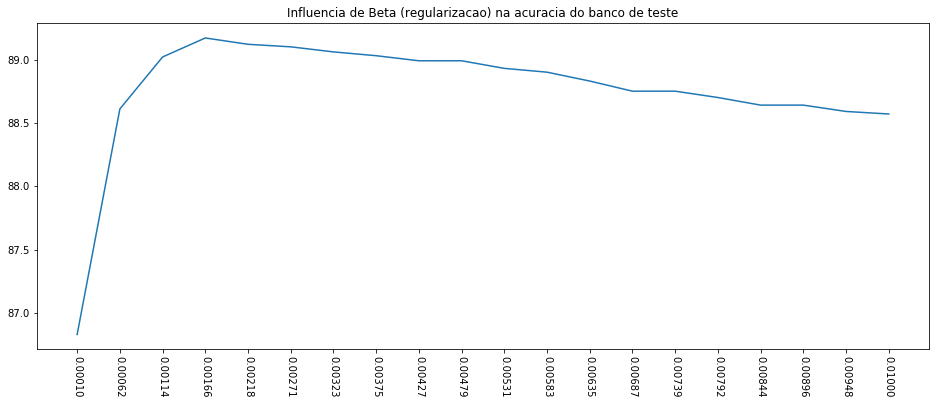

In [10]:
plt.figure(figsize=(16,6))
plt.plot(accuracies)
plt.xticks(range(beta_vals.shape[0]), ['{0:.5f}'.format(beta) for beta in beta_vals], rotation = 270)
plt.title('Influencia de Beta (regularizacao) na acuracia do banco de teste')

### Neural Network

In [11]:
batch_size = 128
hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():
    # Input data
    tf_train_dataset = tf.placeholder(tf.float32, shape = (batch_size, image_size*image_size))
    tf_train_labels  = tf.placeholder(tf.float32, shape = (batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset  = tf.constant(test_dataset)
    
    # Variables
    weights = tf.Variable(tf.truncated_normal([image_size*image_size, hidden_nodes]))
    biases  = tf.Variable(tf.zeros([hidden_nodes]))
    hidden_weights = tf.Variable(tf.truncated_normal([hidden_nodes, num_labels]))
    hidden_biases  = tf.Variable(tf.zeros([num_labels]))
    beta    = tf.placeholder(tf.float32)
    
    # Training computation
    relu = tf.nn.relu(tf.matmul(tf_train_dataset, weights) + biases)
    
    logits = tf.matmul(relu, hidden_weights) + hidden_biases
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels)
                          + beta*tf.nn.l2_loss(weights))
    
    # Optimizer
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    # Predictions
    train_prediction = tf.nn.softmax(logits)
    
    valid_prediction_hidden = tf.nn.relu(tf.matmul(tf_valid_dataset, weights) + biases)
    valid_prediction = tf.nn.softmax(tf.matmul(valid_prediction_hidden, hidden_weights) + hidden_biases)
    
    test_prediction_hidden = tf.nn.relu(tf.matmul(tf_test_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(test_prediction_hidden, hidden_weights) + hidden_biases)

In [12]:
num_steps = 3001
beta_vals = np.linspace(1e-4, 1e-2, 20)

accuracies = []
for beta_ in beta_vals:
    print('Beta: {0}'.format(beta_))
    
    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        
        for step in range(num_steps):
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)

            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            
            feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels, beta:beta_}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
            
            if step % 1000 == 0:
                print("Minibatch loss at step {0}: {1}".format(step, l))
                print("Minibatch accuracy: {0:.1f}%".format(accuracy(predictions, batch_labels)))
                print("Validation accuracy: {0:.1f}%".format(accuracy(valid_prediction.eval(), valid_labels)))
                
        accuracy_score = accuracy(test_prediction.eval(), test_labels)
        accuracies.append(accuracy_score)
        print("Test accuracy: {0:.1f}% \n".format(accuracy_score))

Beta: 0.0001
Minibatch loss at step 0: 374.14239501953125
Minibatch accuracy: 4.7%
Validation accuracy: 30.9%
Minibatch loss at step 1000: 35.3478889465332
Minibatch accuracy: 81.2%
Validation accuracy: 80.7%
Minibatch loss at step 2000: 26.6298770904541
Minibatch accuracy: 86.7%
Validation accuracy: 81.5%
Minibatch loss at step 3000: 23.67142105102539
Minibatch accuracy: 82.0%
Validation accuracy: 82.3%
Test accuracy: 89.5% 

Beta: 0.0006210526315789474
Minibatch loss at step 0: 564.4607543945312
Minibatch accuracy: 7.8%
Validation accuracy: 34.4%
Minibatch loss at step 1000: 107.47504425048828
Minibatch accuracy: 78.9%
Validation accuracy: 81.3%
Minibatch loss at step 2000: 54.594757080078125
Minibatch accuracy: 89.8%
Validation accuracy: 83.6%
Minibatch loss at step 3000: 29.382781982421875
Minibatch accuracy: 84.4%
Validation accuracy: 85.0%
Test accuracy: 91.8% 

Beta: 0.0011421052631578948
Minibatch loss at step 0: 695.8947143554688
Minibatch accuracy: 10.9%
Validation accuracy: 

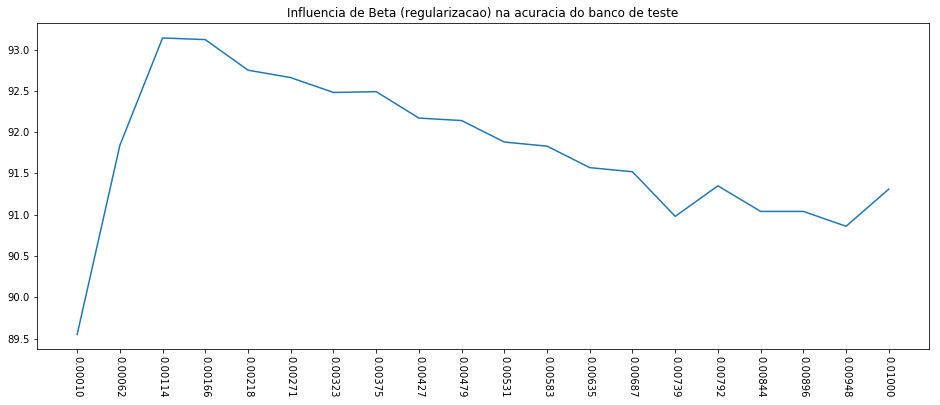

In [13]:
plt.figure(figsize=(16,6))
plt.plot(accuracies)
plt.xticks(range(beta_vals.shape[0]), ['{0:.5f}'.format(beta) for beta in beta_vals], rotation = 270)
plt.title('Influencia de Beta (regularizacao) na acuracia do banco de teste')

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

In [15]:
batch_size = 50000
hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():
    # Input
    tf_train_dataset = tf.placeholder(tf.float32, shape = (batch_size, image_size*image_size))
    tf_train_labels  = tf.placeholder(tf.float32, shape = (batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset  = tf.constant(test_dataset)
    
    # Variables
    weights = tf.Variable(tf.truncated_normal([image_size*image_size, hidden_nodes]))
    biases  = tf.Variable(tf.zeros([hidden_nodes]))
    hidden_weights = tf.Variable(tf.truncated_normal([hidden_nodes, num_labels]))
    hidden_biases  = tf.Variable(tf.zeros([num_labels]))
    beta = tf.placeholder(tf.float32)
    
    # Training computation
    relu = tf.nn.relu(tf.matmul(tf_train_dataset, weights) + biases)
    
    logits = tf.matmul(relu, hidden_weights) + hidden_biases
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)
                         + beta*tf.nn.l2_loss(weights))
    
    # Optimizer
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    # Predictions
    train_predictions = tf.nn.softmax(logits)
    
    valid_predictions_hidden = tf.nn.relu(tf.matmul(tf_valid_dataset, weights) + biases)
    valid_predictions = tf.nn.softmax(tf.matmul(valid_predictions_hidden, hidden_weights) + hidden_biases)
    
    test_predictions_hidden = tf.nn.relu(tf.matmul(tf_test_dataset, weights) + biases)
    test_predictions = tf.nn.softmax(tf.matmul(test_predictions_hidden, hidden_weights) + hidden_biases)

In [19]:
num_steps = 51
num_batches = 3
beta_ = 0.00218
    
with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()

    for step in range(num_steps):
        #offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        offset = step % num_batches

        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), : ]

        feed_dict = {tf_train_dataset:batch_data, tf_train_labels:batch_labels, beta:beta_}
        _, l, predictions = session.run([optimizer, loss, train_predictions], feed_dict=feed_dict)

        if step % 5 == 0:
            print("Minibatch loss at step {0}: {1:.1f}".format(step, l))
            print("Minibatch accuracy: {0:.1f}%".format(accuracy(predictions, batch_labels)))
            print("Validation accuracy: {0:.1f}%".format(accuracy(valid_predictions.eval(), valid_labels)))

    print("Test accuracy: {0:.1f}".format(accuracy(test_predictions.eval(), test_labels)))

Minibatch loss at step 0: 1011.6
Minibatch accuracy: 12.7%
Validation accuracy: 37.4%
Minibatch loss at step 5: 810.0
Minibatch accuracy: 63.8%
Validation accuracy: 69.2%
Minibatch loss at step 10: 735.6
Minibatch accuracy: 76.7%
Validation accuracy: 77.6%
Minibatch loss at step 15: 693.8
Minibatch accuracy: 80.6%
Validation accuracy: 79.5%
Minibatch loss at step 20: 677.9
Minibatch accuracy: 80.9%
Validation accuracy: 79.8%
Minibatch loss at step 25: 665.7
Minibatch accuracy: 80.5%
Validation accuracy: 79.7%
Minibatch loss at step 30: 680.9
Minibatch accuracy: 75.4%
Validation accuracy: 78.6%
Minibatch loss at step 35: 648.6
Minibatch accuracy: 81.3%
Validation accuracy: 79.8%
Minibatch loss at step 40: 639.2
Minibatch accuracy: 81.2%
Validation accuracy: 79.4%
Minibatch loss at step 45: 630.9
Minibatch accuracy: 80.9%
Validation accuracy: 78.5%
Minibatch loss at step 50: 687.4
Minibatch accuracy: 74.3%
Validation accuracy: 75.0%
Test accuracy: 82.3


**Como o número de batches é pequeno (=3), há também muitos parâmetros para otimizar, mesmo com a regularização, a capacidade de generalização é muito fraca. Logo, com apenas poucos passos, a rede atinge 100% no treinamento, mas não consegue boas taxas nos bancos de validação e teste.**

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [20]:
batch_size = 256
hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():
    # Input
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size*image_size))
    tf_train_labels  = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset  = tf.constant(test_dataset)
    
    # Variables
    weights = tf.Variable(tf.truncated_normal([image_size*image_size, hidden_nodes]))
    biases  = tf.Variable(tf.zeros([hidden_nodes]))
    hidden_weights = tf.Variable(tf.truncated_normal([hidden_nodes, num_labels]))
    hidden_biases  = tf.Variable(tf.zeros([num_labels]))
    beta = tf.placeholder(tf.float32)
    
    # Training computation
    relu = tf.nn.relu(tf.matmul(tf_train_dataset, weights) + biases)
    dropout = tf.nn.dropout(relu, 0.5)
    
    logits = tf.matmul(dropout, hidden_weights) + hidden_biases
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels)
                         + beta*tf.nn.l2_loss(weights))
    
    # Optimizer
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    # Predictions
    train_predictions = tf.nn.softmax(logits)
    
    valid_predictions_hidden = tf.nn.relu(tf.matmul(tf_valid_dataset, weights) + biases)
    valid_predictions = tf.nn.softmax(tf.matmul(valid_predictions_hidden, hidden_weights) + hidden_biases)
    
    test_predictions_hidden = tf.nn.relu(tf.matmul(tf_test_dataset, weights) + biases)
    test_predictions = tf.nn.softmax(tf.matmul(test_predictions_hidden, hidden_weights) + hidden_biases)

In [23]:
num_steps = 101
num_batches = 3
beta_ = 0.00218

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    
    for step in range(num_steps):
        offset  = step % num_batches
        
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        
        feed_dict = {tf_train_dataset:batch_data, tf_train_labels:batch_labels, beta:beta_}
        _, l, predictions = session.run([optimizer, loss, train_predictions], feed_dict=feed_dict)
        
        if step % 5 == 0:
            print("Minibatch loss at step {0}: {1:.1f}".format(step, l))
            print("Minibatch accuracy: {0:.1f}%".format(accuracy(predictions, batch_labels)))
            print("Validation accuracy: {0:.1f}%".format(accuracy(valid_predictions.eval(), valid_labels)))

    print("Test accuracy: {0:.1f}%".format(accuracy(test_predictions.eval(), test_labels)))

Minibatch loss at step 0: 1118.2
Minibatch accuracy: 9.0%
Validation accuracy: 38.6%
Minibatch loss at step 5: 962.0
Minibatch accuracy: 63.3%
Validation accuracy: 66.4%
Minibatch loss at step 10: 679.8
Minibatch accuracy: 92.6%
Validation accuracy: 73.7%
Minibatch loss at step 15: 658.4
Minibatch accuracy: 95.7%
Validation accuracy: 74.3%
Minibatch loss at step 20: 651.5
Minibatch accuracy: 96.9%
Validation accuracy: 74.2%
Minibatch loss at step 25: 643.8
Minibatch accuracy: 97.3%
Validation accuracy: 75.4%
Minibatch loss at step 30: 640.9
Minibatch accuracy: 96.1%
Validation accuracy: 75.2%
Minibatch loss at step 35: 631.6
Minibatch accuracy: 98.8%
Validation accuracy: 75.6%
Minibatch loss at step 40: 620.7
Minibatch accuracy: 98.8%
Validation accuracy: 75.1%
Minibatch loss at step 45: 615.3
Minibatch accuracy: 97.7%
Validation accuracy: 74.9%
Minibatch loss at step 50: 607.2
Minibatch accuracy: 98.4%
Validation accuracy: 73.0%
Minibatch loss at step 55: 600.3
Minibatch accuracy: 98.

**
Pode-se perceber que a acurácia de 100% nos minibatchs é mais difícil de conseguir ou, pelo menos, manter. A acurácia final no banco de teste foi melhorada em 3,1%.
**

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


In [5]:
batch_size = 128
hidden_nodes_1 = 1024
hidden_nodes_2 = 100
beta = 0.00218

graph = tf.Graph()
with graph.as_default():
    # input
    tf_train_dataset = tf.placeholder(tf.float32, shape = (batch_size, image_size*image_size))
    tf_train_labels  = tf.placeholder(tf.float32, shape = (batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset  = tf.constant(test_dataset)
    
    # Variables
    weights_1 = tf.Variable(tf.truncated_normal([image_size*image_size, hidden_nodes_1], stddev=np.sqrt(2.0 / (image_size*image_size))))
    weights_2 = tf.Variable(tf.truncated_normal([hidden_nodes_1, hidden_nodes_2], stddev=np.sqrt(2.0 / hidden_nodes_1)))
    weights_3 = tf.Variable(tf.truncated_normal([hidden_nodes_2, num_labels], stddev=np.sqrt(2.0 / hidden_nodes_2)))
    biases_1  = tf.Variable(tf.zeros([hidden_nodes_1]))
    biases_2  = tf.Variable(tf.zeros([hidden_nodes_2]))
    biases_3  = tf.Variable(tf.zeros([num_labels]))
    global_step = tf.Variable(0)
    
    # Training computation
    hidden_relu_1 = tf.nn.relu(tf.matmul(tf_train_dataset, weights_1) + biases_1)    
    hidden_relu_2 = tf.nn.relu(tf.matmul(hidden_relu_1, weights_2) + biases_2)
    
    logits = tf.matmul(hidden_relu_2, weights_3) + biases_3
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels)
                         + beta*(tf.nn.l2_loss(weights_1) + tf.nn.l2_loss(weights_2) + tf.nn.l2_loss(weights_3)))
    
    # Optimizer
    learning_rate = tf.train.exponential_decay(0.5, global_step, 1000, 0.5, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
    
    # Predictions
    train_predictions = tf.nn.softmax(logits)
    
    valid_predictions_1 = tf.nn.relu(tf.matmul(tf_valid_dataset, weights_1) + biases_1)
    valid_predictions_2 = tf.nn.relu(tf.matmul(valid_predictions_1, weights_2) + biases_2)
    valid_predictions   = tf.nn.softmax(tf.matmul(valid_predictions_2, weights_3) + biases_3)
    
    test_predictions_1 = tf.nn.relu(tf.matmul(tf_test_dataset, weights_1) + biases_1)
    test_predictions_2 = tf.nn.relu(tf.matmul(test_predictions_1, weights_2) + biases_2)
    test_predictions   = tf.nn.softmax(tf.matmul(test_predictions_2, weights_3) + biases_3)

In [7]:
num_steps = 5001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        
        feed_dict = {tf_train_dataset:batch_data, tf_train_labels:batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_predictions], feed_dict=feed_dict)
        
        if step % 500 == 0:
            print("Minibatch loss at step {0}: {1:.1f}".format(step, l))
            print("Minibatch accuracy: {0:.1f}%".format(accuracy(predictions, batch_labels)))
            print("Validation accuracy: {0:.1f}%".format(accuracy(valid_predictions.eval(), valid_labels)))

    print("Test accuracy: {0:.1f}".format(accuracy(test_predictions.eval(), test_labels)))

Minibatch loss at step 0: 4.3
Minibatch accuracy: 7.0%
Validation accuracy: 29.6%
Minibatch loss at step 500: 1.1
Minibatch accuracy: 89.1%
Validation accuracy: 85.2%
Minibatch loss at step 1000: 0.8
Minibatch accuracy: 82.8%
Validation accuracy: 86.0%
Minibatch loss at step 1500: 0.5
Minibatch accuracy: 93.0%
Validation accuracy: 87.3%
Minibatch loss at step 2000: 0.5
Minibatch accuracy: 92.2%
Validation accuracy: 87.3%
Minibatch loss at step 2500: 0.5
Minibatch accuracy: 89.8%
Validation accuracy: 87.8%
Minibatch loss at step 3000: 0.5
Minibatch accuracy: 87.5%
Validation accuracy: 87.8%
Minibatch loss at step 3500: 0.6
Minibatch accuracy: 88.3%
Validation accuracy: 88.3%
Minibatch loss at step 4000: 0.5
Minibatch accuracy: 91.4%
Validation accuracy: 88.2%
Minibatch loss at step 4500: 0.5
Minibatch accuracy: 89.8%
Validation accuracy: 88.5%
Minibatch loss at step 5000: 0.5
Minibatch accuracy: 89.8%
Validation accuracy: 88.7%
Test accuracy: 94.6


In [39]:
batch_size = 256
hidden_nodes_1 = 1024
hidden_nodes_2 = 256
hidden_nodes_3 = 128
beta = 1e-3

graph = tf.Graph()
with graph.as_default():
    # input
    tf_train_dataset = tf.placeholder(tf.float32, shape = (batch_size, image_size*image_size))
    tf_train_labels  = tf.placeholder(tf.float32, shape = (batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset  = tf.constant(test_dataset)
    
    # Variables
    weights_1 = tf.Variable(tf.truncated_normal([image_size*image_size, hidden_nodes_1], stddev=np.sqrt(2.0 / (image_size*image_size))))
    weights_2 = tf.Variable(tf.truncated_normal([hidden_nodes_1, hidden_nodes_2], stddev=np.sqrt(2.0 / hidden_nodes_1)))
    weights_3 = tf.Variable(tf.truncated_normal([hidden_nodes_2, hidden_nodes_3], stddev=np.sqrt(2.0 / hidden_nodes_2)))
    weights_4 = tf.Variable(tf.truncated_normal([hidden_nodes_3, num_labels], stddev=np.sqrt(2.0 / hidden_nodes_3)))
    biases_1  = tf.Variable(tf.zeros([hidden_nodes_1]))
    biases_2  = tf.Variable(tf.zeros([hidden_nodes_2]))
    biases_3  = tf.Variable(tf.zeros([hidden_nodes_3]))
    biases_4  = tf.Variable(tf.zeros([num_labels]))
    global_step = tf.Variable(0)
    
    # Training computation
    hidden_relu_1 = tf.nn.relu(tf.matmul(tf_train_dataset, weights_1) + biases_1)
    dropout_1 = tf.nn.dropout(hidden_relu_1, 0.5)
    
    hidden_relu_2 = tf.nn.relu(tf.matmul(dropout_1, weights_2) + biases_2)    
    hidden_relu_3 = tf.nn.relu(tf.matmul(hidden_relu_2, weights_3) + biases_3)
    
    logits = tf.matmul(hidden_relu_3, weights_4) + biases_4
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels)
                         + beta*(tf.nn.l2_loss(weights_1) + tf.nn.l2_loss(weights_2) + 
                                 tf.nn.l2_loss(weights_3) + tf.nn.l2_loss(weights_4)))
    
    # Optimizer
    learning_rate = tf.train.exponential_decay(0.5, global_step, 4000, 0.5, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
    
    # Predictions
    train_predictions = tf.nn.softmax(logits)
    
    valid_predictions_1 = tf.nn.relu(tf.matmul(tf_valid_dataset, weights_1) + biases_1)
    valid_predictions_2 = tf.nn.relu(tf.matmul(valid_predictions_1, weights_2) + biases_2)
    valid_predictions_3 = tf.nn.relu(tf.matmul(valid_predictions_2, weights_3) + biases_3)
    valid_predictions   = tf.nn.softmax(tf.matmul(valid_predictions_3, weights_4) + biases_4)
    
    test_predictions_1 = tf.nn.relu(tf.matmul(tf_test_dataset, weights_1) + biases_1)
    test_predictions_2 = tf.nn.relu(tf.matmul(test_predictions_1, weights_2) + biases_2)
    test_predictions_3 = tf.nn.relu(tf.matmul(test_predictions_2, weights_3) + biases_3)
    test_predictions   = tf.nn.softmax(tf.matmul(test_predictions_3, weights_4) + biases_4)

In [40]:
num_steps = 10000

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        
        feed_dict = {tf_train_dataset:batch_data, tf_train_labels:batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_predictions], feed_dict=feed_dict)
        
        if step % 1000 == 0:
            print("Minibatch loss at step {0}: {1:.5f}".format(step, l))
            print("Minibatch accuracy: {0:.1f}%".format(accuracy(predictions, batch_labels)))
            print("Validation accuracy: {0:.1f}%".format(accuracy(valid_predictions.eval(), valid_labels)))

    print("Test accuracy: {0:.1f}%".format(accuracy(test_predictions.eval(), test_labels)))

Minibatch loss at step 0: 3.47364
Minibatch accuracy: 9.4%
Validation accuracy: 25.8%
Minibatch loss at step 1000: 0.84605
Minibatch accuracy: 89.1%
Validation accuracy: 86.6%
Minibatch loss at step 2000: 0.64179
Minibatch accuracy: 87.1%
Validation accuracy: 86.9%
Minibatch loss at step 3000: 0.60596
Minibatch accuracy: 86.7%
Validation accuracy: 88.0%
Minibatch loss at step 4000: 0.49939
Minibatch accuracy: 89.1%
Validation accuracy: 88.5%
Minibatch loss at step 5000: 0.53701
Minibatch accuracy: 87.5%
Validation accuracy: 89.1%
Minibatch loss at step 6000: 0.42958
Minibatch accuracy: 90.6%
Validation accuracy: 89.4%
Minibatch loss at step 7000: 0.40041
Minibatch accuracy: 91.4%
Validation accuracy: 89.2%
Minibatch loss at step 8000: 0.46084
Minibatch accuracy: 89.5%
Validation accuracy: 89.6%
Minibatch loss at step 9000: 0.43164
Minibatch accuracy: 90.6%
Validation accuracy: 90.0%
Test accuracy: 95.7%


Esse foi o meu melhor resultado: **95.7%**.